# Import packages

In [17]:
%load_ext autoreload
%autoreload 2

import os
import sys

import xarray as xr
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

from utils.utils import reduceDataByDay

# Set display options for pandas
pd.set_option('display.max_columns', None)  # Set to None for unlimited columns or specify a number
# Now, when one displays xarray DataArrays or Datasets, the columns will be wider


# Get the current working directory of the notebook
current_dir = os.getcwd()
# Add the parent directory of the notebook to the Python path
# root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
root_dir = os.path.abspath(current_dir)
sys.path.append(root_dir)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

## Util data

In [18]:
# Define the path to the data directory file
data_dir_path = os.path.join(root_dir, "utils", "data_dir.yml")

with open(data_dir_path, 'r') as ymlfile:
    data_dir = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
data_dir_src = data_dir['data_dir_camels_spat']
data_dir_out = data_dir['data_dir_camels_spat_nh']

In [19]:
data_gen_path = os.path.join(root_dir, "utils", "data_general.yml")

with open(data_gen_path, 'r') as ymlfile:
    data_gen = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
countries = data_gen['countries']
camels_spat_metadata = data_gen['camels_spat_metadata']
camels_spat_unusable = data_gen['camels_spat_unusable']
data_sources = data_gen['data_sources']

### Filter usable basins and create txt file

In [20]:
# df_metadata = pd.read_csv(os.path.join(data_dir_src, camels_spat_metadata))
# df_unusable = pd.read_csv(os.path.join(data_dir_src, camels_spat_unusable))
df_metadata = pd.read_csv(os.path.join('data', camels_spat_metadata))
# df_unusable = pd.read_csv(os.path.join('data', camels_spat_unusable))

# # Create a dict to map the Country to a list of Station_id
# # Create a dictionary to map Country to a list of Station_id
# country_station_map = {}
# for index, row in df_metadata.iterrows():
#     country = row['Country']
#     station_id = row['Station_id']
#     if country in country_station_map:
#         country_station_map[country].append(station_id)
#     else:
#         country_station_map[country] = [station_id]

## Basin data

In [21]:
file_name = 'camels_spat_metadata.csv'
# file_name = 'rhbn_stations.csv'
# Load data as pandas dataframe
df = pd.read_csv(os.path.join(data_dir_src, file_name), sep=',', header=0)
# Print first 5 rows
len(df)

1698

In [22]:
basin_data_path = os.path.join(data_dir_src, 'basin_data')
list_basin_files = sorted(os.listdir(basin_data_path))

# Filter folders by country name (3 first letters) - create a dictionary
basin_data_path_dict = {}
for country in countries:
    basin_data_path_dict[country] = [basin for basin in list_basin_files if basin[:3] == country]
len(basin_data_path_dict['CAN']) + len(basin_data_path_dict['USA'])

2

In [23]:
basin_data_path_dict[countries[0]]

['CAN_01AD002', 'CAN_01AD003']

In [24]:
relative_path_forc = data_dir['relative_path_forcing']
relative_path_targ = data_dir['relative_path_target']
for country in countries:
    
    # Create a folder for each country
    country_dir = os.path.join(data_dir_out, f'CAMELS_spat_{country}')
    if not os.path.exists(country_dir ):
        os.makedirs(country_dir)
    else:
        print(f"Directory {country_dir} already exists")
        
    print(country)
    for basin_f in basin_data_path_dict[country]:
        print(basin_f)
        ## Load input data
        df_src_dict = {}
        for src in data_sources:
            folder2load = os.path.join(basin_data_path, basin_f, relative_path_forc)
            
            eras_files = sorted([f for f in os.listdir(folder2load) if src in f])
            print(src, len(eras_files))

            # Initialize an empty list to store the xarray datasets
            datasets = []
            # Iterate over the files and load each dataset
            print("Loading Input datasets...")
            for file2load in eras_files[:]:
                basin_data = xr.open_dataset(os.path.join(folder2load, file2load))
                # # # Print variables
                # print(list(basin_data.data_vars))
                # # Filter variables by the ones in data_gen['input_vars']
                # basin_data_filtered = basin_data[data_gen['input_vars']]
                print(list(basin_data.data_vars))
                datasets.append(basin_data)
            # Concatenate all datasets along the 'time' dimension
            print("Concatenating Input datasets...")
            concatenated_dataset = xr.concat(datasets, dim='time')
            # # Concatenate all datasets along the 'time' dimension, specifying compat='override'
            # concatenated_dataset = xr.concat(datasets, dim='time', compat='override')
                
            # Reduce basin_data to daily values
            print("Reducing Input data to daily values...")
            basin_data_reduced = reduceDataByDay(concatenated_dataset, data_gen['input_vars'], data_gen['sum_vars'])
            # Convert the reduced basin_data to a DataFrame, dropping the 'hru' dimension
            print("Converting Input to DataFrame...")
            basin_data_df = basin_data_reduced.to_dataframe().droplevel('hru').reset_index()
            
            # Save to dict
            df_src_dict[src] = basin_data_df
            
        # Merge dataframes in the dictionary
        print("Merging Input DataFrames...")
        df_merged_inp = df_src_dict[data_sources[0]].merge(df_src_dict[data_sources[1]], on='time')
        
        # Rename time by date
        df_merged_inp.rename(columns={'time': 'date'}, inplace=True)
        
        ## Load target data
        target_data = xr.open_dataset(os.path.join(basin_data_path, basin_f, relative_path_targ, f'{basin_f}_daily_flow_observations.nc'))
        
        # Convert to DataFrame
        print("Converting Target to DataFrame...")
        df_target = target_data.to_dataframe().reset_index()
        # Rename time by date
        df_target.rename(columns={'time': 'date'}, inplace=True)
        # drop column 'time_bnds' and remove duplicates
        df_target.drop(columns=['time_bnds'], inplace=True)
        df_target = df_target.drop_duplicates(subset=['date'])
        
        # Merge input and target dataframes
        print("Merging Input and Target DataFrames...")
        df_merged = df_merged_inp.merge(df_target, on='date')
        
        # Save to file
        print("Saving to file...")
        df_merged.to_csv(os.path.join(country_dir, basin_f + '.csv'), index=False)
        
        # # Save to file
        # print("Saving to file...")
        # df_merged_inp.to_csv(os.path.join(country_dir, basin_f + '.csv'), index=False)
        
        # # Save target to file
        # df_target.to_csv(os.path.join(country_dir, basin_f + '_target.csv'), index=False)
        
        

Directory ../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH/CAMELS_spat_CAN already exists
CAN
CAN_01AD002
ERA5 853
Loading Input datasets...
['e', 'hruId', 'latitude', 'longitude', 'mper', 'msdwlwrf', 'msdwswrf', 'msnlwrf', 'msnswrf', 'mtpr', 'q', 'rh', 'sp', 't', 'u', 'v', 'w', 'phi', 'time_bnds']
['e', 'hruId', 'latitude', 'longitude', 'mper', 'msdwlwrf', 'msdwswrf', 'msnlwrf', 'msnswrf', 'mtpr', 'q', 'rh', 'sp', 't', 'u', 'v', 'w', 'phi', 'time_bnds']
['e', 'hruId', 'latitude', 'longitude', 'mper', 'msdwlwrf', 'msdwswrf', 'msnlwrf', 'msnswrf', 'mtpr', 'q', 'rh', 'sp', 't', 'u', 'v', 'w', 'phi', 'time_bnds']
['e', 'hruId', 'latitude', 'longitude', 'mper', 'msdwlwrf', 'msdwswrf', 'msnlwrf', 'msnswrf', 'mtpr', 'q', 'rh', 'sp', 't', 'u', 'v', 'w', 'phi', 'time_bnds']
['e', 'hruId', 'latitude', 'longitude', 'mper', 'msdwlwrf', 'msdwswrf', 'msnlwrf', 'msnswrf', 'mtpr', 'q', 'rh', 'sp', 't', 'u', 'v', 'w', 'phi', 'time_bnds']
['e', 'hruId', 'latitude', 'longitude', 'mper', 

In [ ]:
list(basin_data.data_vars)

['e',
 'hruId',
 'latitude',
 'longitude',
 'mper',
 'msdwlwrf',
 'msdwswrf',
 'msnlwrf',
 'msnswrf',
 'mtpr',
 'q',
 'rh',
 'sp',
 't',
 'u',
 'v',
 'w',
 'phi',
 'time_bnds']

In [ ]:
folder2load = os.path.join(basin_data_path, basin_data_path_dict[countries[0]][0], 'observations')
file2load = basin_data_path_dict[countries[0]][0] + '_daily_flow_observations.nc'
basin_obs = xr.open_dataset(os.path.join(folder2load, file2load))
basin_obs

<xarray.Dataset>
Dimensions:                   (time: 25933, nbnds: 2)
Coordinates:
  * time                      (time) datetime64[ns] 1950-01-01 ... 2020-12-31
  * nbnds                     (nbnds) int32 1 2
Data variables:
    q_obs_data_quality        (time) object ...
    q_obs                     (time) float64 ...
    q_obs_is_ice_affected     (time) int32 ...
    q_obs_is_partial_day      (time) int32 ...
    q_obs_is_dry_day          (time) int32 ...
    q_obs_is_estimated_value  (time) int32 ...
    time_bnds                 (nbnds, time) datetime64[ns] ...
Attributes:
    title:        CAMELS-spat streamflow data
    conventions:  CF-1.10
    source:       Streamflow derived from observed water levels
    country:      CAN
    station:      01AD002
    institution:  Water Survey of Canada
    references:   Original data extracted from the Environment and Climate Ch...
    history:      2023-08-02 11:32:55 | File prepared using CAMELS-spat scrip...
    comment:      Water Survey of Canada calculates daily average flow values...

In [ ]:
variable_names = [var for var in list(basin_obs.variables.keys()) if 'obs' in var]
variable_names

['q_obs_data_quality',
 'q_obs',
 'q_obs_is_ice_affected',
 'q_obs_is_partial_day',
 'q_obs_is_dry_day',
 'q_obs_is_estimated_value']

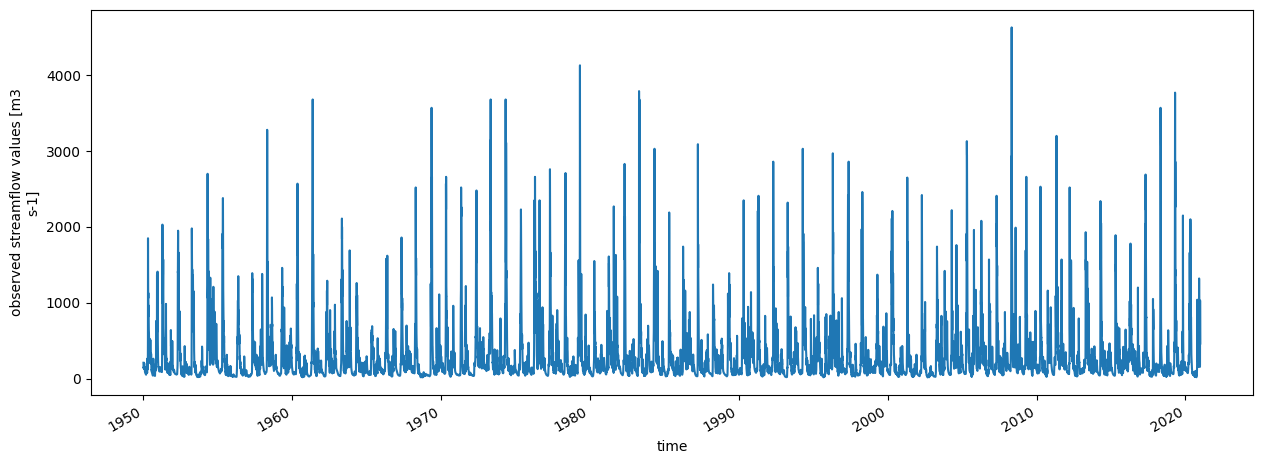

In [ ]:
var_to_plot = variable_names[1]
# Plot the data
basin_obs[var_to_plot].plot.line(hue='station_id', figsize=(15, 5))